In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from math import sqrt, ceil

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [2]:
with open('../data/data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

(81, 32, 32, 3)


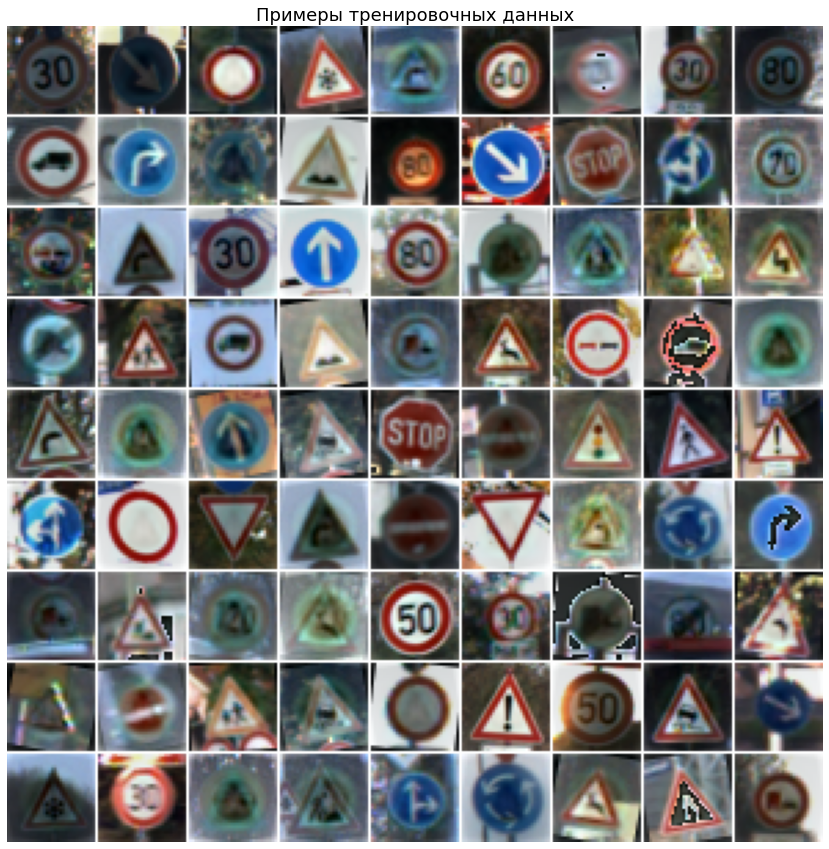

In [4]:
%matplotlib inline
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


examples = data['x_train'][81:162, :, :, :]
print(examples.shape)

fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Примеры тренировочных данных', fontsize=18)

plt.show()

fig.savefig('../training_examples.png')
plt.close()

In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               4096500   
_________________________________________________________________
dense_3 (Dense)              (None, 43)                21543     
Total params: 4,118,939
Trainable params: 4,118,939
Non-trainable params: 0
_________________________________________________________________


In [8]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
epochs = 15
history = model.fit(data['x_train'], data['y_train'],
                    batch_size=5, epochs=epochs,
                    validation_data=(data['x_validation'], data['y_validation']),
                    callbacks=[annealer], verbose=1)

Epoch 1/15
17398/17398 [==============================] - 107s 6ms/step - loss: 0.5199 - accuracy: 0.8651 - val_loss: 0.5838 - val_accuracy: 0.8551

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 32, 32, 3)
[4]


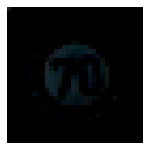

(1, 43)
ClassId: 4
Label: Speed Limit (70km/h)


In [14]:
index = 80
x_input = data['x_test'][index:index+1]
print(x_input.shape)
y_input = data['y_test'][index:index+1]
print(y_input)

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

plt.show()

scores = model.predict(x_input)
print(scores.shape) # (43,)

prediction = np.argmax(scores)
print('ClassId:', prediction)

def label_text(file):
    label_list = []
    r = pd.read_csv(file)
    for name in r['SignName']:
        label_list.append(name)

    return label_list

labels = label_text('../data/label_names.csv')

print('Класс:', labels[prediction])

In [16]:
name = '../models/model-new.h5'
model.save(name)